# Identifying sentences that convey meaningful semantic relation between entities within the sentence - Exploratory Data Analysis (EDA)


The objective of this notebook is to present a brief exploratory data analysis (EDA) of the sampled dataset that will be later used.

In [1]:
from IPython.display import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.stats import powerlaw
import numpy as np

## Part 1: Named Entities EDA

The Named Entities analysis was conducted during the dataset generation.
The distribution of named entity occurances, along with their corresponding labels, follows a heavy-tail distibution pattern, as can be seen below:

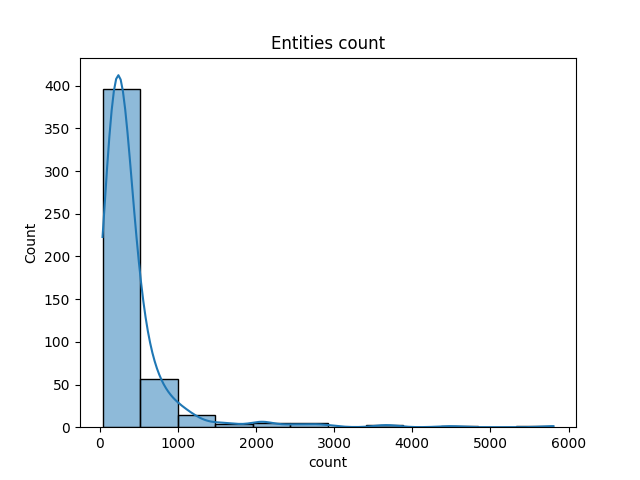

In [2]:
Image(filename='./sampled_sentences_stats/entities_count.png')

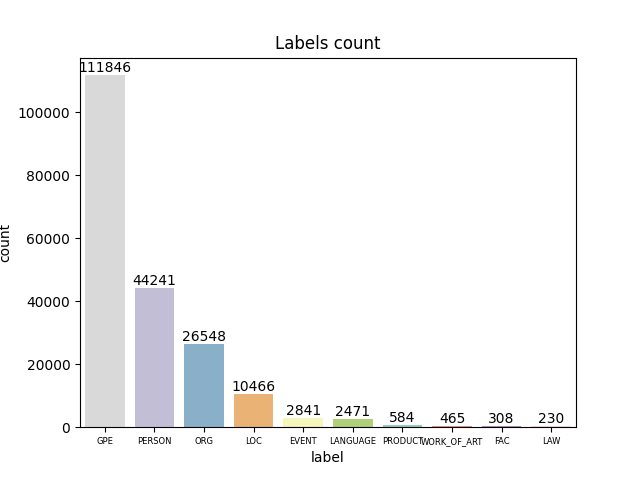

In [3]:
Image(filename='./sampled_sentences_stats/labels_count.png')

We can see that Named-entities pairs follow a heavy-tail distibution as well:

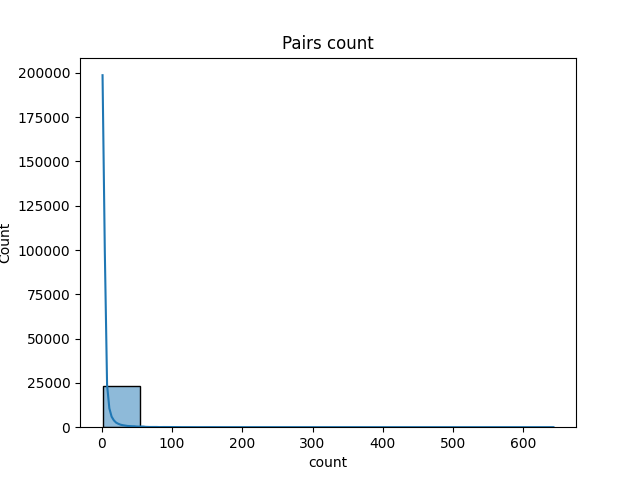

In [4]:
Image(filename='./sampled_sentences_stats/pairs_count.png')

The occurrences of the paired labels can be visualized using a heatmap. For instance, it can be observed that pairs labeled as GPE-GPE (geopolitical entities) are the most common.

Other frequent combinations include: GPE-LOC (geopolitical entity - location), GPE-ORG (geopolitical entity - organization), GPE-PERSON, LOC-LOC (location - location), ORG-ORG (organization - organization), ORG-PERSON, and PERSON-PERSON.

*Notes:*

* In this context, each pair is counted twice due to the symmetric nature of the relation. For example, a pair consisting of GPE and PERSON will be counted once as (GPE, PERSON) and then again as (PERSON, GPE).

* In the original dataset, there were more occurrences of the PERSON-PERSON relation compared to the GPE-GPE relation. However, in the sampled dataset, this relation is reversed. One possible explanation for this is that names of individual people are fewer by nature compared to names of places. As a result, fewer person named entities met the requirement of appearing more than 1000 times in the texts.


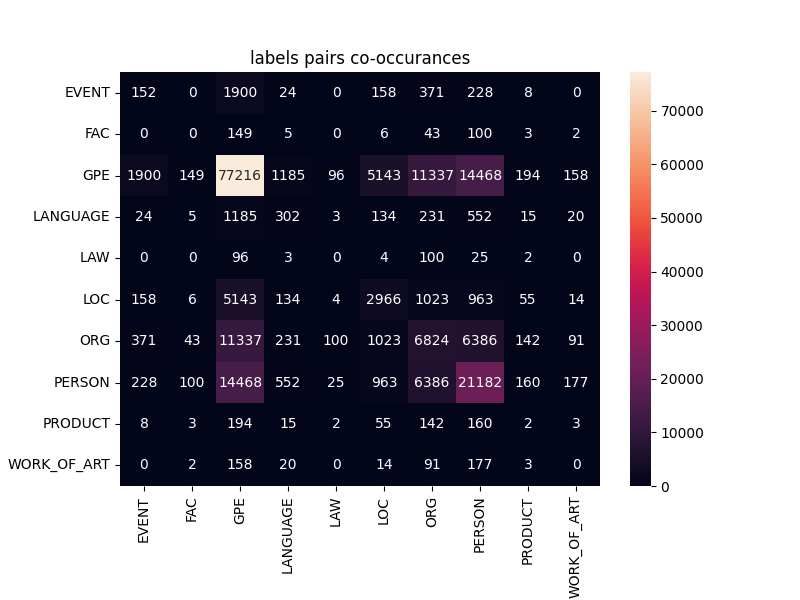

In [5]:
Image(filename='./sampled_sentences_stats/pairs_labels_count.png')

## Part 2: Exploring the Mutual Information (MI) Score

### Exploring the MI for the entire dataset

The mutual information (MI) analysis also reveals a clear power-law distribution. It is apparent that lower MI values occur frequently, indicating a lower level of relationship between the entities. Conversely, entities with a higher level of relationship are less common.

In [6]:
dataset_path = '../data/data.csv'
df = pd.read_csv(dataset_path)

In [7]:
df['mi_score'].describe()

count    1.000000e+05
mean     5.286175e-05
std      1.584569e-04
min      5.764018e-09
25%      3.543488e-07
50%      3.435019e-06
75%      3.152790e-05
max      1.254153e-03
Name: mi_score, dtype: float64

Text(0.5, 1.0, 'Mutial information distribution')

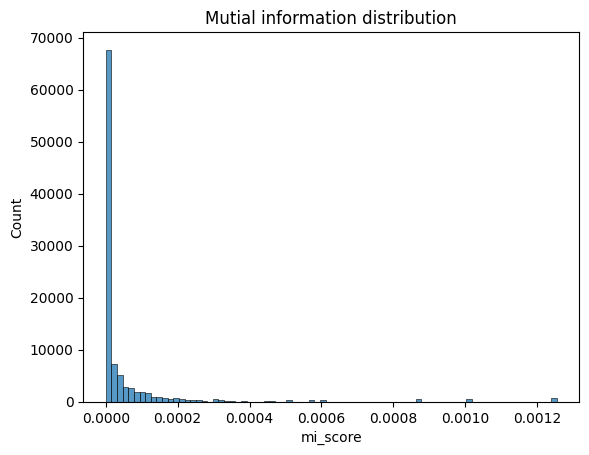

In [8]:
sns.histplot(data=df['mi_score'], kde=False, binrange=(min(df['mi_score']), max(df['mi_score'])), bins=80)
plt.title('Mutial information distribution')

### Estimating Probability Distribution for MI

To estimate the probability, we will fit the parameters of a power-law distribution:

In [9]:
def fit_powerlaw_dist(values):
    fit_params = powerlaw.fit(values)
    fitted_distribution = powerlaw(*fit_params)
    return fitted_distribution

In [10]:
def plot_fitted_dist(values, fitted_distribution, label, bins=80):
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(values, bins=bins, density=False, alpha=0.5, label=label)
    # Plot the fitted distribution using the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    fitted_pdf = fitted_distribution.pdf(bin_centers)
    ax.plot(bin_centers, fitted_pdf, color='r', label='Fitted Power-law Distribution')

    plt.title(f'Histogram of {label}')
    plt.xlabel(label)
    plt.ylabel('Frequency')

    plt.legend()
    plt.show()

In [11]:
def create_fitted_precentiles(values, fitted_distribution):
    percentiles = np.arange(10, 110, 10)  # Generate an array from 10 to 100 in increments of 10
    data_percentiles = np.percentile(values, percentiles)
    distribution_precentiles = [fitted_distribution.ppf(p / 100) for p in percentiles]

    precentiles_df = pd.DataFrame({
        'Percentile': percentiles,
        'data percentiles': data_percentiles,
        'distribution precentiles': distribution_precentiles
    }).set_index('Percentile')

    return precentiles_df

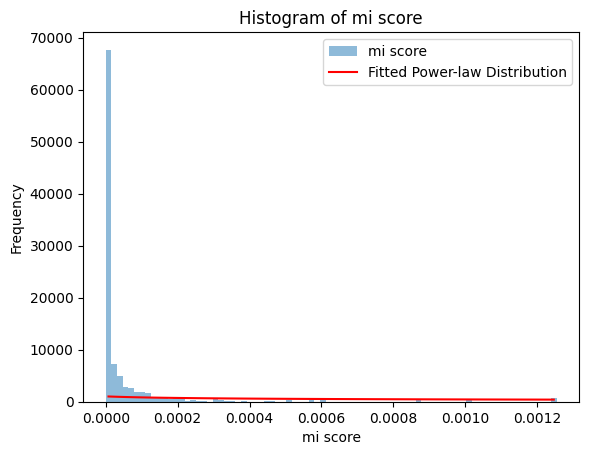

            data percentiles  distribution precentiles
Percentile                                            
10              4.944503e-08                 -0.000135
20              2.052330e-07                 -0.000076
30              5.615861e-07                  0.000011
40              1.417653e-06                  0.000124
50              3.435019e-06                  0.000259
60              8.241617e-06                  0.000417
70              1.905495e-05                  0.000597
80              4.726300e-05                  0.000796
90              1.195712e-04                  0.001016
100             1.254153e-03                  0.001254


In [12]:
scores = df['mi_score']
fitted_dist = fit_powerlaw_dist(scores)
plot_fitted_dist(scores, fitted_dist, 'mi score')
print(create_fitted_precentiles(scores, fitted_dist))

### Pairs with highest and lowest MI score

In [13]:
sorted_df = df.sort_values(by='mi_score', ascending=False)

The 5 pairs with highest MI score:

In [14]:
for index, s in sorted_df.head(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.mi_score:.5f} {s.sent}')

1990665 Scully PERSON Mulder PERSON 0.00125 In the morning Scully suspiciously asks Mulder if he moved the car in the night.
1565504 Scully PERSON Mulder PERSON 0.00125 Scully begins to question Berquist's motives, noting that she was the reason Mulder decided to look into this investigation.
422067 Mulder PERSON Scully PERSON 0.00125 Mulder and Scully determine that one of the dead men belonged to an Islamic terrorist group, the Isfahan, and using the ATM video are able to track down Lauren.
422062 Mulder PERSON Scully PERSON 0.00125 In this episode, Mulder and Scully investigate the death of two muggers and encounter an office worker who may be haunted by the spirit of her dead boss, who is using her to uncover his murderer; and discover covert arms deals made with Middle Eastern radicals.
2360307 Scully PERSON Mulder PERSON 0.00125 Scully visits Mulder in hospital, where he is recovering from his gunshot wound.


The 5 pairs with lowest MI score:

In [15]:
for index, s in sorted_df.tail(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.mi_score:.5f} {s.sent}')

1988918 Bible WORK_OF_ART Alexander PERSON 0.00000 Other members of the bishop's household were Ralph Gubion, who became abbot of St Albans, and an Italian Bible scholar named Guido or Wido, who taught that subject while serving Alexander.
2714574 Ross PERSON Ryan PERSON 0.00000 Ross was originally hesitant to audition for another soap opera after her stint on Ryan ’ s Hope as Diana Douglas from 1985 to 1987, which she compared to "working in a morgue" because the show was constantly threatened with cancellation.
315979 Apple ORG Pittsburgh GPE 0.00000 Meanwhile, Apple, Google, Uber, and Intel have joined the 1,600 technology firms choosing to operate out of Pittsburgh.
1891799 Minogue PERSON Tokyo GPE 0.00000 The lyrics were written by Minogue in Tokyo during her trips with her boyfriend, Stéphane Sednaoui, in late-1995.
2237157 Kelly PERSON Perry PERSON 0.00000 There's nary a hint of her pristine pop past on Kelly's hip-grinding 'Outrageous' or Perry's' Girls & Boys'.


### Exploring the MI for each labels-pair

I decided to display only the top 8 label pairs in the dataset for mutual information (MI) analysis. As expected, we often observe a power-law distribution, with an additional cluster representing the pairs that frequently appeared together.

In [16]:
def plot_type_mi_hist_plot(df, type1, type2, bins='auto'):
    df1 = df[( (df['label1'] == type1) & (df['label2'] == type2) ) | ( (df['label2'] == type1) & (df['label1'] == type2) )]
    sns.histplot(data=df1['mi_score'], kde=False, bins=bins)
    plt.title(f'Mutial information distribution for labels: {type1}-{type2}')

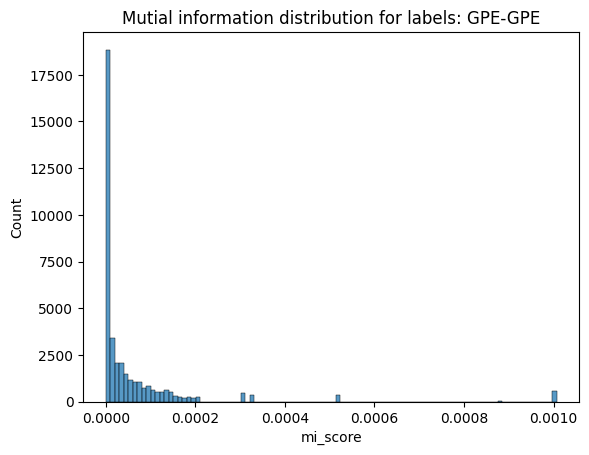

In [17]:
plot_type_mi_hist_plot(df, 'GPE', 'GPE', bins=100)

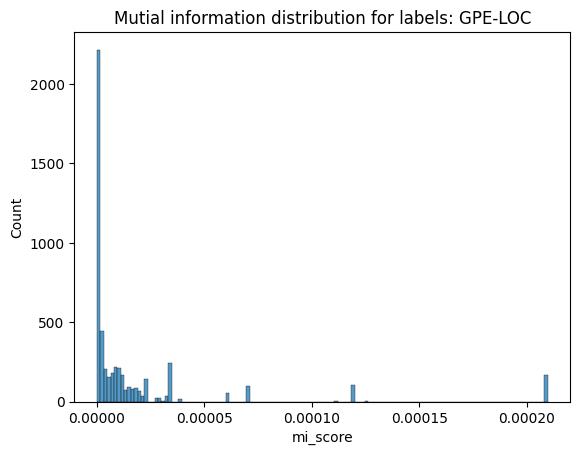

In [18]:
plot_type_mi_hist_plot(df, 'GPE', 'LOC')

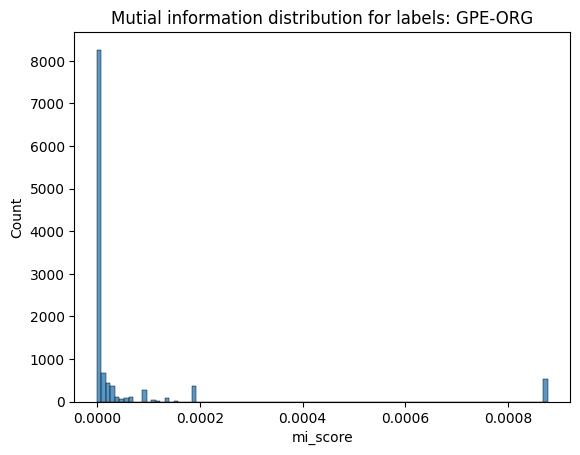

In [19]:
plot_type_mi_hist_plot(df, 'GPE', 'ORG', bins=100)

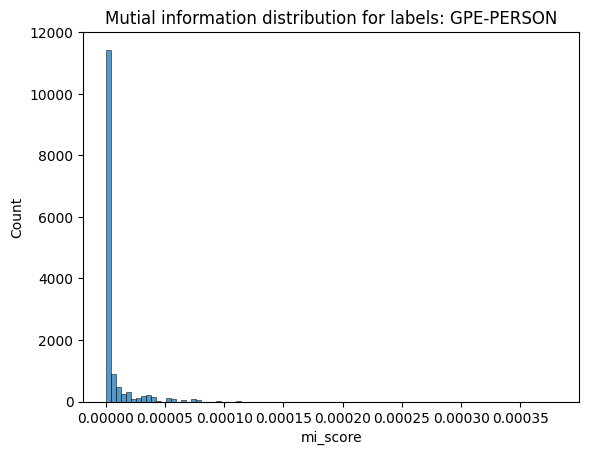

In [20]:
plot_type_mi_hist_plot(df, 'GPE', 'PERSON', bins=90)

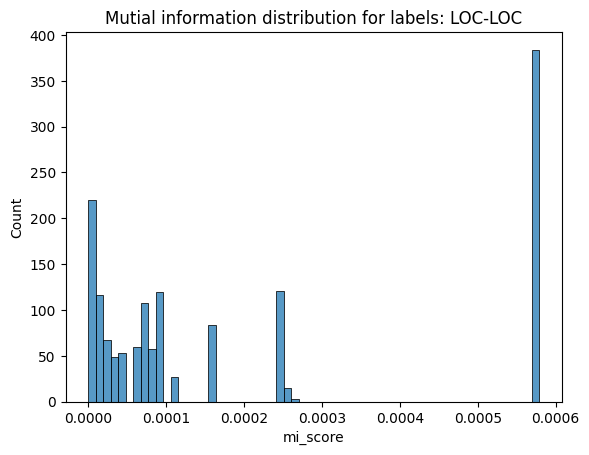

In [21]:
plot_type_mi_hist_plot(df, 'LOC', 'LOC', bins=60)

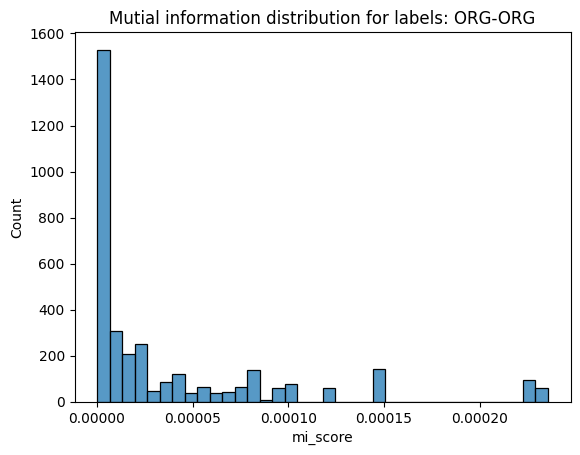

In [22]:
plot_type_mi_hist_plot(df, 'ORG', 'ORG')

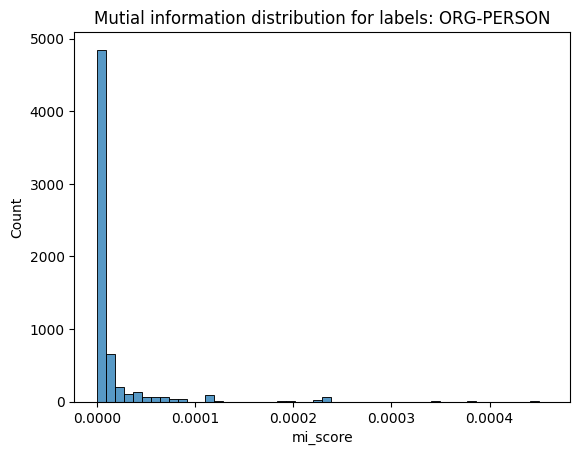

In [23]:
plot_type_mi_hist_plot(df, 'ORG', 'PERSON', bins=50)

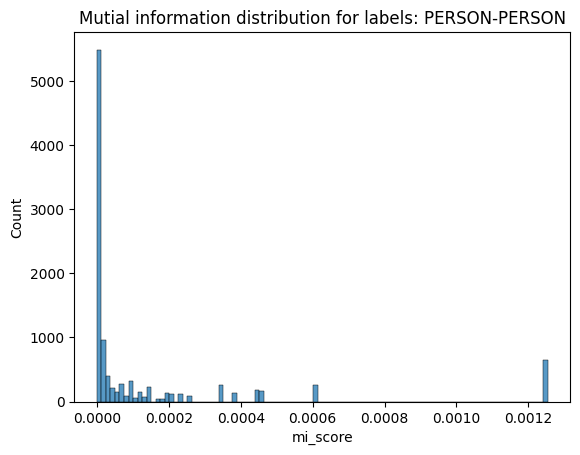

In [24]:
plot_type_mi_hist_plot(df, 'PERSON', 'PERSON', bins=100)

## Part 3: Exploring the Pointwise Mutual Information (PMI) Score

### Exploring the PMI for the entire dataset

The distribution of PMI values demonstrates a bell-shaped pattern.

Text(0.5, 1.0, 'PMI distribution')

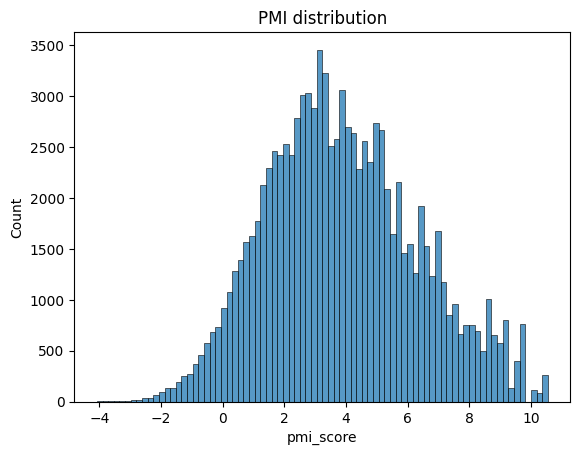

In [25]:
sns.histplot(data=df['pmi_score'], kde=False, binrange=(min(df['pmi_score']), max(df['pmi_score'])), bins=80)
plt.title('PMI distribution')

In [26]:
sorted_df = df.sort_values(by='pmi_score', ascending=False)

In [27]:
print(f"min pmi score: {min(df['pmi_score'])}, max pmi score: {max(df['pmi_score'])}")
print(f"pmi range: {max(df['pmi_score']- min(df['pmi_score']))}")

min pmi score: -4.079740656975896, max pmi score: 10.554719076005409
pmi range: 14.634459732981306


### Pairs with highest and lowest PMI score

In [28]:
sorted_df = df.sort_values(by='pmi_score', ascending=False)

The 5 pairs with highest PMI score:

In [29]:
for index, s in sorted_df.head(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.pmi_score} {s.sent}')

1672193 Gilbert PERSON Sullivan PERSON 10.554719076005409 The overtures from the Gilbert and Sullivan operas remain popular, and there are many recordings of them.
983666 Gilbert PERSON Sullivan PERSON 10.554719076005409 Gilbert, Sullivan and Carte brought lawsuits in the U.S. and tried for many years to control the American performance copyrights over their operas, or at least to claim some royalties, without success.
397563 Sullivan PERSON Gilbert PERSON 10.554719076005409 Sullivan recalled, "Until Gilbert took the matter in hand choruses were dummy concerns, and were practically nothing more than a part of the stage setting.
397558 Gilbert PERSON Sullivan PERSON 10.554719076005409 The judge's song, "When I, good friends, was called to the Bar" was followed by a string of similar patter songs that would come to epitomise Gilbert and Sullivan's collaboration.
397545 Gilbert PERSON Sullivan PERSON 10.554719076005409 As the first Savoy opera, Trial by Jury marked an important moment in 

Let's examine 'Gilbert' and 'Sullivan' co-occurances **in the sampled dataset** as the pair with top PMI score:

In [30]:
def get_coappearnce_count(df, ent1, ent2):
    return len(sorted_df[(df['ent1'] == ent1) & (sorted_df['ent2'] == ent2)]) + \
            len(sorted_df[(df['ent1'] == ent2) & (sorted_df['ent2'] == ent1)])

def get_separate_coappearnce_count(df, ent1, ent2):
    ent1_count = len(sorted_df[(df['ent1'] == ent1) & (sorted_df['ent2'] != ent2)]) + \
            len(sorted_df[(df['ent1'] != ent2) & (sorted_df['ent2'] == ent1)])
    ent2_count = len(sorted_df[(df['ent1'] != ent1) & (sorted_df['ent2'] == ent2)]) + \
            len(sorted_df[(df['ent1'] == ent2) & (sorted_df['ent2'] != ent1)])
    return ent1_count, ent2_count

ent1 = 'Gilbert'
ent2 = 'Sullivan'
coappearnce = get_coappearnce_count(sorted_df, ent1, ent2)

print(f'co-apperances: {coappearnce}')

ent1_appearance, ent2_appearance = get_separate_coappearnce_count(sorted_df, ent1, ent2)
print(f'{ent1} appeared without {ent2} {ent1_appearance} times')
print(f'{ent2} appeared without {ent1} {ent2_appearance} times')

co-apperances: 262
Gilbert appeared without Sullivan 110 times
Sullivan appeared without Gilbert 96 times


The 5 pairs with lowest PMI score:

In [31]:
for index, s in sorted_df.tail(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.pmi_score} {s.sent}')

533038 Bart PERSON England GPE -3.641707850324873 Bart hopes that his hero Krusty, will save them, but Krusty remains unaware of the camp's nature, and is currently visiting England for the Wimbledon Tennis Tournament.
1331587 England GPE Simpsons ORG -3.8446311273246425 Wallis returned to England and with the shipping business still buoyant, the Simpsons moved into a large flat with a staff of servants.
1173351 IGN ORG England GPE -3.9438445549414745 IGN's Jeremy Dunham noted that "Clock Tower 3 successfully captur [es] the dirty, musty look of England's serial killer underworld... [it] is straight out of a Mary Shelley novel."
1136136 US GPE Sun ORG -4.0563014626954095 US 60 enters the Valley of the Sun within Pinal County borders in Apache Junction.
834982 Beyoncé PERSON England GPE -4.079740656975896 After Beyoncé finished her concert at the Trent FM Arena in Nottingham, England on November 20, 2009, she announced to the crowd that a new album would be released the next year.


Initially, I was taken aback to discover that pairs like "New York" and "New York" or "India" and "India" exhibit low PMI. However, upon further reflection, it does make sense: when an entity is mentioned in a sentence, it is usually referred to later using a pronoun rather than its full name again. As a result, such occurrences are quite infrequent.

## Part 4: Exploring the correlation between PMI and MI

We can see that the correlation is not low but not high:

In [32]:
correlation = sorted_df['mi_score'].corr(sorted_df['pmi_score'])
print(f"Correlation between 'mi_score' and 'pmi_score': {correlation}")

Correlation between 'mi_score' and 'pmi_score': 0.5137554607737063


## Part 5: Exploring sentences length

<AxesSubplot: >

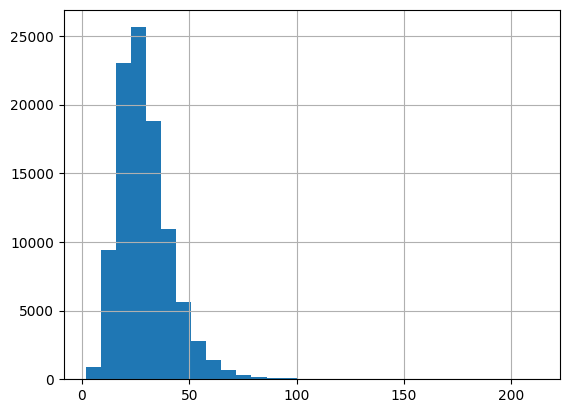

In [33]:
seq_len = [len(i.split()) for i in df['sent']]

pd.Series(seq_len).hist(bins = 30)